In [34]:
#imports and call stored df
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


%store -r cb_df_final
%store -r foursquare_df_final
%store -r yelp_df_final

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [ ]:
#combine individually with cb
cb_foursquare = cb_df_final.merge(foursquare_df_final, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])
cb_yelp = cb_df_final.merge(yelp_df_final, how='inner', left_on=['latitude', 'longitude'], right_on=['latitude', 'longitude'])

combined_df_final = pd.concat([cb_foursquare, cb_yelp], ignore_index=False)


#drop these columns because not common and will be difficult to replace NaN with appropriate numbers and not common among API's
combined_df_final = combined_df_final.drop(columns=['popularity', 'total_photos', 'total_tips'])
combined_df_final



**At bottom**
Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [225]:
#check for duplicates
combined_df_final.shape

(6240, 9)

In [226]:
duplicate_rows = combined_df_final[combined_df_final.duplicated()]
print("number of duplicate rows:", duplicate_rows.shape)

number of duplicate rows: (0, 9)


In [ ]:
combined_df_final.describe()
# I have some 0 values...will do further analysis below to see quantity before determining approach

In [36]:
# I see that my max distance is well over the 1000m radius limit, I will remove these because I am only interested for 1000m and less
combined_df_final = combined_df_final.drop(combined_df_final[combined_df_final['distance'] > 1000].index)



In [ ]:
#check to see if values match
combined_df_final.describe()

In [ ]:
combined_df_final.count()
print(combined_df_final.isnull().sum())


Graphs for data of interest

In [ ]:
sns.boxplot(x=combined_df_final['distance'])

In [ ]:
plt.hist(combined_df_final['price'], bins=4)

In [ ]:
sns.boxplot(x=combined_df_final['rating'])

In [ ]:
sns.boxplot(x=combined_df_final['total_ratings'])

/tmp/ipykernel_24964/3198911796.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = combined_df_final.corr()


<Axes: >

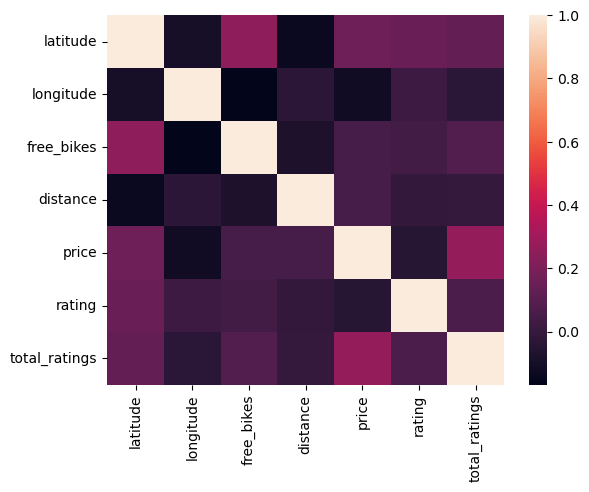

In [48]:
correlation = combined_df_final.corr()
sns.heatmap(correlation)

In [ ]:
#removing outliers if any
Q1 = combined_df_final.quantile(0.25, numeric_only=True)
Q3 = combined_df_final.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
print(IQR)

In [ ]:
#The number of outliers varies on a case by case basis
non_outliers_max = combined_df_final[~((combined_df_final < (Q3 + (1.5 * IQR))).any(axis=1))]
non_outliers_min = combined_df_final[~((combined_df_final < (Q1 - (1.5 * IQR))).any(axis=1))]
no_outliers = pd.concat([non_outliers_min, non_outliers_max])
no_outliers.describe()

Graphs for df with no NaN and outliers removed; I just wanted to see the distribution for my own interests

In [40]:
no_outlier_NaN = no_outliers.dropna()

<Axes: xlabel='distance'>

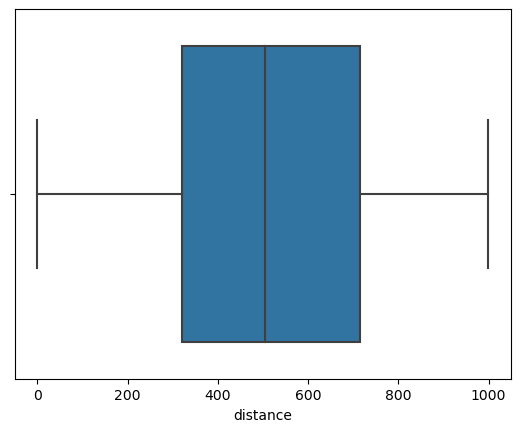

In [41]:
sns.boxplot(x=no_outlier_NaN['distance'])

(array([2723.,  480.,  163.]),
 array([2.        , 2.66666667, 3.33333333, 4.        ]),
 <BarContainer object of 3 artists>)

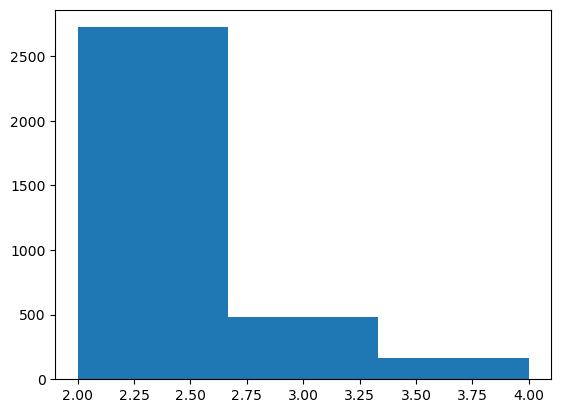

In [44]:
plt.hist(no_outlier_NaN['price'], bins=3)

<Axes: xlabel='rating'>

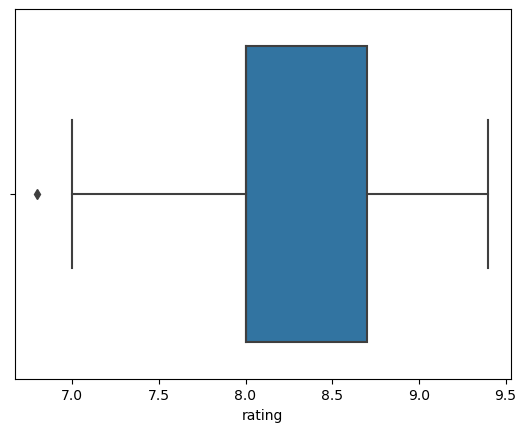

In [45]:
sns.boxplot(x=no_outlier_NaN['rating'])

<Axes: xlabel='total_ratings'>

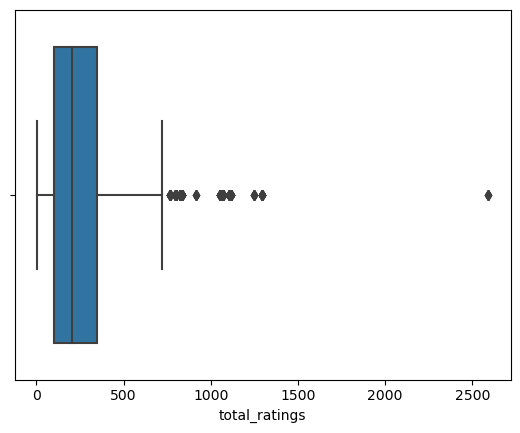

In [46]:
sns.boxplot(x=no_outlier_NaN['total_ratings'])

# Database

In [11]:
import sqlite3
from sqlite3 import Error

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("connection was successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [12]:
connection = create_connection("python_project.db")

connection was successful


query execution function and create table

In [13]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [14]:
def to_sql(table_name, df_name, conn):
    df_name.to_sql(table_name, connection, if_exists='replace', index=True, index_label='ID')

def read_sql(query_string):
    return pd.read_sql(query_string, connection) #connection variable is specific to this notebook



In [30]:
#Create Tables
#cb_bikes df
to_sql('city_bikes', cb_df_final, connection)
to_sql('yelp', yelp_df_final, connection)
to_sql('foursquare', foursquare_df_final, connection)
to_sql('restaurants', combined_df_final, connection)



In [25]:
# Test tables
city_bikes = "select * from city_bikes"
yelp = "select * from yelp"
foursquare = "select * from foursquare"
cb_yelp_foursquare = "select * from restaurants" 

Look at the data before and after the join to validate your data.

In [17]:
#city bikes before join
read_sql(city_bikes)

,ID,latitude,longitude,free_bikes
0,0,49.262487,-123.114397,8.0
1,1,49.274566,-123.121817,6.0
2,2,49.279764,-123.110154,16.0
3,3,49.260599,-123.113504,6.0
4,4,49.264215,-123.117772,7.0
...,...,...,...,...
239,239,49.285670,-123.112543,10.0
240,240,49.250940,-123.101306,3.0
241,241,49.280977,-123.035969,15.0
242,242,49.270783,-123.141564,18.0


In [26]:
#yelp before join
read_sql(yelp)

,ID,latitude,longitude,name,total_ratings,rating,price,distance,address
0,0,49.262487,-123.114397,La Taqueria Pinche Taco Shop,682,8.0,2.0,169.517456,"2450 Yukon Street, Vancouver, BC V5Z 3V6, Canada"
1,1,49.262487,-123.114397,Cactus Club Cafe,144,7.0,2.0,221.483933,"575 Broadway W, Vancouver, BC V5Z 1E6, Canada"
2,2,49.262487,-123.114397,Anh and Chi,627,8.0,2.0,1284.210576,"3388 Main Street, Vancouver, BC V5V 3M7, Canada"
3,3,49.262487,-123.114397,Vij's Restaurant,397,8.0,3.0,547.596751,"3106 Cambie Street, Vancouver, BC V5Z 2W2, Canada"
4,4,49.262487,-123.114397,Suyo Modern Peruvian,19,9.0,NaN,1349.232719,"3475 Main Street, Vancouver, BC V5V 3M9, Canada"
...,...,...,...,...,...,...,...,...,...
3829,3829,49.270783,-123.141564,Novo Italian,156,8.0,2.0,541.171382,"2118 Burrard Street, Vancouver, BC V6J 3H6, Ca..."
3830,3830,49.270783,-123.141564,Charqui,50,5.0,2.0,589.139556,"1955 Cornwall Avenue, Vancouver, BC V6J 1C9, C..."
3831,3831,49.270783,-123.141564,Grapes & Soda,44,9.0,2.0,514.785326,"1541 W 6th Avenue, Vancouver, BC V6J 1R1, Canada"
3832,3832,49.270783,-123.141564,Maxine's Cafe & Bar,77,8.0,2.0,1087.141065,"1325 Burrard Street, Vancouver, BC V6Z 2B7, Ca..."


In [27]:
#foursquare before join
read_sql(foursquare)

,ID,latitude,longitude,distance,name,popularity,price,rating,address,total_photos,total_ratings,total_tips
0,0,49.262487,-123.114397,96,Marulilu Cafe,0.973994,2.0,8.2,"451W Broadway W (at Cambie St), Vancouver BC V...",129.0,112.0,32.0
1,1,49.262487,-123.114397,299,Aperture Coffee Bar,0.930162,1.0,8.7,"243 West Broadway (at Alberta St), Vancouver B...",72.0,94.0,29.0
2,2,49.262487,-123.114397,336,Caffe Cittadella,0.950162,2.0,8.6,"2310 Ash St (at W 7th Ave), Vancouver BC V5Z 3C2",138.0,81.0,27.0
3,3,49.262487,-123.114397,430,Milano Coffee,0.977331,2.0,9.0,"156 8th Ave W (btwn Columbia & Manitoba St), V...",130.0,121.0,32.0
4,4,49.262487,-123.114397,250,Rogue Kitchen & Wetbar,0.981296,3.0,8.3,"602W Broadway W (at Ash St), Vancouver BC V5Z 1G1",138.0,127.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2424,2424,49.270783,-123.141564,467,Siegel's Bagels,0.984881,1.0,8.8,"1883 Cornwall Ave (at Cypress St), Vancouver B...",153.0,156.0,40.0
2425,2425,49.270783,-123.141564,509,The Liberty Distillery,0.966597,NaN,8.7,"2 1494 Old Bridge St, Vancouver BC V6H 3S6",136.0,91.0,20.0
2426,2426,49.270783,-123.141564,525,Cheesecake Etc,0.977655,1.0,8.7,"2141 Granville St (at W 6th Ave), Vancouver BC...",188.0,156.0,40.0
2427,2427,49.270783,-123.141564,605,Rain or Shine Ice Cream,0.980744,3.0,9.0,"1926 4th Ave W (btwn Cypress & Maple), Vancouv...",186.0,196.0,50.0


In [31]:
##combined data
read_sql(cb_yelp_foursquare)

,ID,latitude,longitude,free_bikes,distance,name,price,rating,address,total_ratings
0,0,49.262487,-123.114397,8.0,96.000000,Marulilu Cafe,2.0,8.2,"451W Broadway W (at Cambie St), Vancouver BC V...",112.0
1,1,49.262487,-123.114397,8.0,299.000000,Aperture Coffee Bar,1.0,8.7,"243 West Broadway (at Alberta St), Vancouver B...",94.0
2,3,49.262487,-123.114397,8.0,430.000000,Milano Coffee,2.0,9.0,"156 8th Ave W (btwn Columbia & Manitoba St), V...",121.0
3,5,49.262487,-123.114397,8.0,225.000000,Elysian Coffee Broadway,1.0,8.2,"590 Broadway W (at Ash St), Vancouver BC V5Z 1E9",199.0
4,8,49.262487,-123.114397,8.0,724.000000,Elysian Coffee,1.0,9.1,"2301 Ontario St (at 7th Ave), Vancouver BC V5T...",75.0
...,...,...,...,...,...,...,...,...,...,...
5451,3815,49.270783,-123.141564,18.0,763.432982,Their There,2.0,8.0,"2042 West 4th Avenue, Vancouver, BC V6J 1M9, C...",113.0
5452,3816,49.270783,-123.141564,18.0,541.171382,Novo Italian,2.0,8.0,"2118 Burrard Street, Vancouver, BC V6J 3H6, Ca...",156.0
5453,3817,49.270783,-123.141564,18.0,589.139556,Charqui,2.0,5.0,"1955 Cornwall Avenue, Vancouver, BC V6J 1C9, C...",50.0
5454,3818,49.270783,-123.141564,18.0,514.785326,Grapes & Soda,2.0,9.0,"1541 W 6th Avenue, Vancouver, BC V6J 1R1, Canada",44.0


In [32]:
#datatypes for cb_yelp_foursquare
pd.read_sql("PRAGMA TABLE_INFO(restaurants)", connection)


,cid,name,type,notnull,dflt_value,pk
0,0,ID,INTEGER,0,None,0
1,1,latitude,REAL,0,None,0
2,2,longitude,REAL,0,None,0
3,3,free_bikes,REAL,0,None,0
4,4,distance,REAL,0,None,0
5,5,name,TEXT,0,None,0
6,6,price,REAL,0,None,0
7,7,rating,REAL,0,None,0
8,8,address,TEXT,0,None,0
9,9,total_ratings,REAL,0,None,0
